### Importing Libraries

In [ ]:
!pip install nltk #Natural Language Toolkit
!pip install demoji #Used for converting emojis into text.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import demoji
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Importing Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Project 1/Dataset/cyberbullying_tweets.csv')

### Exploratory Data Analysis

In [ ]:
dataset.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [ ]:
dataset.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [ ]:
#There are no null values in the dataset

In [ ]:
dataset.shape

(47692, 2)

In [ ]:
dataset.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [ ]:
dataset.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [ ]:
dataset['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [ ]:
#The cyberbullying_type is equally split as we can see from the above data.

In [ ]:
dataset.duplicated().sum()

36

In [ ]:
dataset.drop_duplicates(subset='tweet_text',keep='first',inplace=True)

In [ ]:
dataset.shape

(46017, 2)

### Encoding cyberbullying_type in the dataset

In [ ]:
ENCODE_DICT = {'not_cyberbullying': 0,
             'gender': 1,
             'religion': 2,
             'other_cyberbullying': 3,
             'age': 4,
             'ethnicity': 5}
dataset['cyberbullying_type'] = dataset.cyberbullying_type.replace(ENCODE_DICT)
print(dataset.cyberbullying_type.unique())

[0 1 2 3 4 5]


In [ ]:
dataset.sample(5)

,tweet_text,cyberbullying_type
19306,"Quran, says 1) donnot kill the innocent 2) don...",2
43256,DAMN! tier 3 madness lol RT @EyeCandyBihhh: “@...,5
27221,The worst part of buying furniture from IKEA i...,3
35172,"#RHONJ Honestly, I don’t give a crap what Dani...",4
32989,"Oh goodness. Being a whore, being a bitch, bei...",4


### Data Cleaning

In [ ]:
def cleantext(text):

  #Removal of hashtags, mentions, urls and retweets
  pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
  text = pattern.sub('', text)

  #Removal of multiple spaces between words and rejoining using single space
  text = " ".join(text.split())

  #Lemmatize each word in the tweet
  #Lemmatization is the process of reducing words to their base or dictionary form, called the lemma.
  lemma = WordNetLemmatizer()
  text = " ".join([lemma.lemmatize(word) for word in text.split()])

  #Instead of removing the emoji, we convert the emoji in the tweet to text and add it back to the tweet
  emoji = demoji.findall(text)
  for emot in emoji:
      text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

  #Expansion of contractions
  contractions = {
        r"can\'t": "can not",
        r"n\'t": " not",
        r"\'re": " are",
        r"\'s": " is",
        r"\'d": " would",
        r"\'ll": " will",
        r"\'ve": " have",
        r"\'m": " am"
    }
  for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

  #Stopwords are commonly used words (e.g., "a", "the", "is") that do not carry significant meaning. Thus stopwords are removed.
  STOPWORDS = set(stopwords.words('english'))
  text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

  #Remove special characters keep only text
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  return text

In [ ]:
dataset['cleaned_tweet_text'] = dataset.tweet_text.apply(lambda text: cleantext(text))

In [ ]:
dataset.sample(5)

,tweet_text,cyberbullying_type,cleaned_tweet_text
23595,Prophet Mohammed started jihad or struggle at ...,2,Prophet Mohammed started jihad struggle time o...
39555,ok then i revistes my old school's insta page ...,4,ok revistes old school insta page i found bull...
17345,What have Indians given!!! 2% population 6% gd...,2,What Indians given population gdp Ur hospita...
20320,@loveconcursall @ottomanland ISIS is a giant e...,2,ISIS giant embarrassment Muslims barbaric thin...
42064,@NeLsoNNaTeR niggers and negro and so on so ur...,5,nigger negro ur dumb fuck took yo white school


### Finding and Removing Duplicates

In [ ]:
dataset["cleaned_tweet_text"].duplicated().sum()

937

In [ ]:
dataset.drop_duplicates("cleaned_tweet_text", inplace=True)

In [ ]:
dataset.shape

(45080, 3)

### Visualization

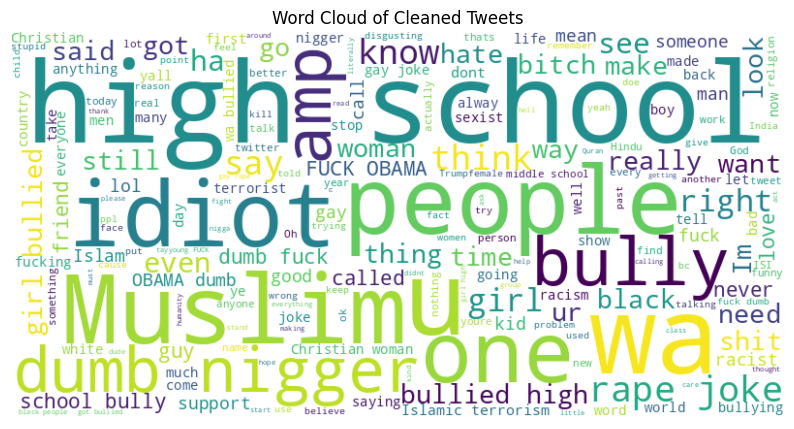

In [ ]:
# Combining all cleaned tweets into a single string
all_tweets = ' '.join(dataset['cleaned_tweet_text'])

# Generating word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Tweets')
plt.show()

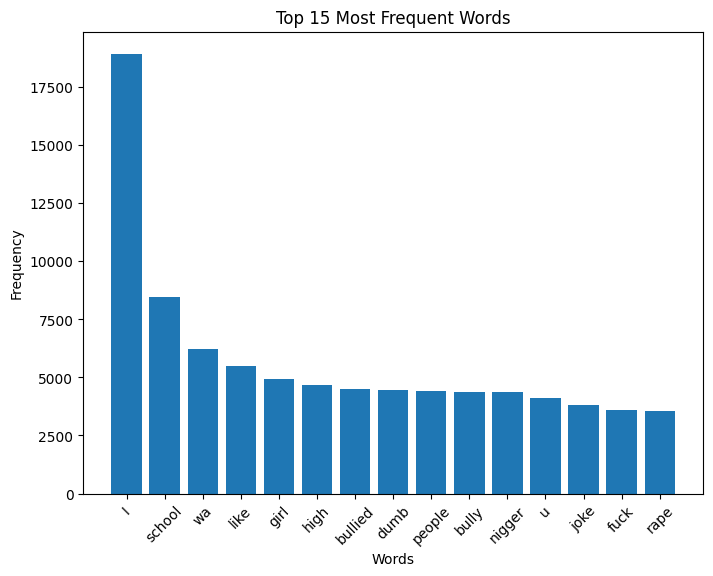

In [ ]:
# Combining all cleaned tweets into a single string
all_tweets = ' '.join(dataset['cleaned_tweet_text'])

# Splitting the cleaned tweet text into words
words = all_tweets.split()

# Counting the frequency of each word
word_counts = Counter(words)

top_n = 15
top_words = dict(word_counts.most_common(top_n))

plt.figure(figsize=(8, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

### Splitting the dataset

In [ ]:
#Splitting into training and testing data
X = dataset['cleaned_tweet_text']
y = dataset['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36064,) (36064,) (9016,) (9016,)


### SVM

In [ ]:
vectorizer = TfidfVectorizer()

X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

print(X_train_tf.shape)
print(X_test_tf.shape)

(36064, 39774)
(9016, 39774)


In [ ]:
from sklearn.svm import SVC

In [ ]:
svm = SVC()

In [ ]:
svm.fit(X_train_tf, y_train)

SVC()

In [ ]:
y_pred_svm = svm.predict(X_test_tf)

In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

Accuracy: 0.8312999112688554


### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Define the hyperparameters and their corresponding values for tuning
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
random_search_svm = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=10, cv=stratified_kfold, random_state=42, n_jobs=-1)

random_search_svm.fit(X_train_tf, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'class_weight': [None, 'balanced'],
                                        'gamma': [0.001, 0.01, 0.1, 1, 10],
                                        'kernel': ['linear', 'rbf']},
                   random_state=42)

In [ ]:
best_params = random_search_svm.best_params_
best_model = random_search_svm.best_estimator_

In [ ]:
y_pred_svm = best_model.predict(X_test_tf)

In [ ]:
rs_accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", rs_accuracy_svm)

Accuracy: 0.8317435669920142


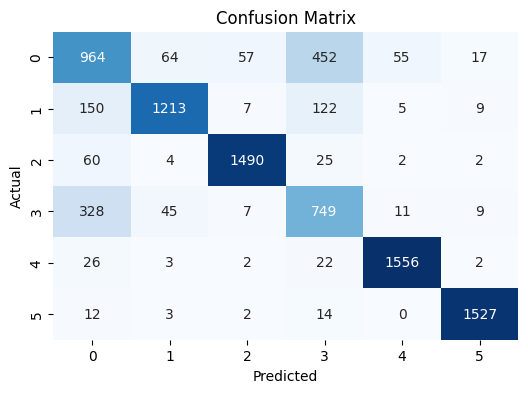

In [ ]:
svm_cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()